# Preliminaries

For this contest, I used only my own open-source library – Seasonality Chains. You can find the info about it and a primer on how to use it with examples for the previous version on my GitHub: <https://github.com/andrewargatkiny/seasonality-chains>

Main new features of the library that weren't present at the time of GitHub guide writing are:
* Trend – option to use trend based on simple linear regression
* Deseasoning – option to deseason low-granularity time-series before applying ARMA/trend prediction
* Prediction period – an option to choose a number of steps which models predicts before next step of Walk-Forward cross-validation

I purposefully didn't use the swiss army knife of ML - tree-based methods or NNs in order to prove two things:
1) Algorithms based on simple statistical concepts and specifically designed to solve a particular task (seasonal time-series forecasting in this case) can do better than general purpose black-box or grey-box ML algos.
2) ML results can be highly and easily interpretable with anyone able to understand the rationale that led to a prediction


In [1]:
import pickle
import pandas as pd
import numpy as np
from schains.tsmodels import UniformModel, SeasonalModel, MedianModel,TimeWeekOfYear
from schains.chains import ChainedModels, CrossValChain

# Dataset preparation and partitioning

Creation of infrastructure for pipeline' operations. Class Dataset encompasses all zone datasets and total one summarizing them to get country-wide total time-series for some frequency period.

In [2]:
REMOVE_OUTLIERS = True
df = pd.read_csv('train.csv', index_col='date', parse_dates=True, sep=';', dayfirst=True,
).sort_index()
df[df.columns[3:]] = df[df.columns[3:]].apply(
    lambda x: x.str.replace(u'\xa0', u'').str.replace(',', '.').astype(float)
)

In [3]:
# It's necessary to set index to period to be compliant with seasonality framework
df = df.set_index(
    pd.PeriodIndex(df.index, freq='d')
)
df.head(10)

,region,oktmo,okato,pasta,legumes,bread,flour,rice,groats,potatoes,...,spice_value,tea_value,ai92,ai95,ai98,dt,ai92_value,ai95_value,ai98_value,dt_value
date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,68,68000000000,68000000000,66.79,84.40,60.73,34.37,66.73,43.63,21.34,...,3593.26,4436.00,41.30,44.37,0.00,44.44,156180.80,95813.37,0.00,16293.86
2019-01-01,61,60000000000,60000000000,73.91,96.49,62.73,33.13,72.29,43.86,29.72,...,10689.10,17193.25,42.16,46.43,50.71,45.46,508465.94,348254.66,5931.82,75636.96
2019-01-01,64,63000000000,63000000000,68.20,89.41,61.91,33.78,68.18,41.08,25.46,...,6165.34,12661.90,40.97,44.49,48.89,45.26,393139.59,129299.96,962.96,25249.79
2019-01-01,62,61000000000,61000000000,72.51,87.65,67.48,33.78,80.14,40.87,27.94,...,4051.15,5396.00,40.81,43.53,51.66,44.26,261811.59,207675.77,245.85,35614.63
2019-01-01,63,36000000000,36000000000,76.89,89.45,74.32,31.77,78.22,44.04,22.32,...,10946.86,17553.88,40.48,43.80,46.15,46.32,569525.56,235634.61,792.04,50875.22
2019-01-01,10,86000000000,86000000000,84.54,96.43,87.41,34.31,73.79,48.03,26.02,...,3649.78,5193.00,40.06,43.68,49.61,47.48,123395.71,84124.73,1430.90,38218.24
2019-01-01,13,89000000000,89000000000,73.19,79.22,55.55,30.00,72.63,42.56,28.87,...,2120.00,3256.00,40.12,44.19,47.20,46.01,122986.03,51951.04,357.27,10418.72
2019-01-01,11,87000000000,87000000000,79.17,97.97,78.99,35.42,70.88,43.68,31.24,...,2891.84,6586.45,41.04,43.82,51.00,47.78,152387.66,79106.30,12.00,16115.30
2019-01-01,12,88000000000,88000000000,85.49,83.39,53.02,30.48,74.75,44.20,26.44,...,2261.00,4969.00,40.52,43.89,48.83,46.89,125524.45,52953.04,334.93,10840.91


In [4]:
ZONE = ['region', 'oktmo', 'okato']
#ZONES_NAMES = df[ZONE].unique()
ZONES_NAMES = df.groupby(ZONE).sum().index.unique(). \
    to_frame().reset_index(drop=True).to_dict('records')
ZONES_CNT=len(ZONES_NAMES)
TIME = 'date'
GOODS = df.columns[3:].values.tolist()
GOODS_CNT = len(GOODS)
print('Zones count:', ZONES_CNT) 
print('Goods count:', GOODS_CNT)


Zones count: 85
Goods count: 75


In [5]:
# Additional indexing of the dataset by zones 
df = df.set_index(ZONE, append=True)

In [6]:
march2020_outliers = {
    'pasta_value': 7, 'legumes_value': 7, 'flour_value': 9,
    'rice_value': 12, 'groats_value': 12, 'potatoes_value': 3,
    'vegetables_value': 8, 'roots_value': 7, 'сabbage_value': 13,
    'sugar_value': 10, 'beef_value': 6, 'chicken_value': 6, 
    'curd_value': 1, 'sour_creame_value': 1, 'butter_value': 7,
    'milk_kefir_value': 7, 'egg_value': 7, 'margarine_value': 8,
    'oil_value': 9, 'salt_value': 12, 'spice_value': 7,
    'tea_value': 7
}
#march2020_outliers = {}

In [7]:
# Preprocessing - filling missing hours in the beginning of 2020 by 
# counterparts in 2021
dfs_zoned = [df.loc[(slice(None), *list(zone.values())), 'pasta':] for zone in ZONES_NAMES]
full_index = pd.period_range(start='2019-01-01', end='2021-03-31', freq='d')
for i in range(ZONES_CNT):
  dfs_zoned[i] = dfs_zoned[i].reset_index(level=[1,2,3], drop=True)
  dfs_zoned[i] = dfs_zoned[i].reindex(full_index)
  if not REMOVE_OUTLIERS: continue
  for col in dfs_zoned[i].columns.values:
    if col in march2020_outliers:
      n_outliers = march2020_outliers[col]
      idx = dfs_zoned[i].loc['2020-03', col].nlargest(n_outliers).index
      replacement = dfs_zoned[i].loc['2020-03', col].median()
      dfs_zoned[i].loc[idx, col] = replacement

In [8]:

freqs = [
    'd', 'w', '2w', 
    'm', '2m', 'q', 'y', '2y'
]
rules_resample = {
    col_name: 'sum' if ('_value' in col_name) else 'mean'
    for col_name in df.columns
 }
class Dataset:
  """
  frequency: frequency of the dataset
  zones: list of zones' datasets
  total: dataset of zones sum (city total)
  """
  def __init__(self, frequency):
    self.frequency = frequency
    self.zones = []
    self.ZONES_NAMES = ZONES_NAMES
    self.GOODS = GOODS
    for i in range(ZONES_CNT):
      self.zones.append(
          dfs_zoned[i].resample(self.frequency).agg(
            rules_resample
          )
      )
    self.total = sum(self.zones)

ds = {freq: Dataset(freq) for freq in freqs}


# Part 4 - Predicting volumes for 2021-05

In this and the next pipeline I continued to build specialized pipelines, optimized to predict certain periods in the future. This particular pipeline selects best models based on its performance at 2nd month prediction from start of each cross-validation series. Look at the code in the function `calc_avg_mae`:

`            chain.prediction = pd.concat([pred[i:i+30] for i in range(0,len(pred),30)][1::2])`

It means that only each second month is taken into account when calculating MAE.

Another distinctive feature of this pipeline: it transforms all volumes' series in such a way that ratio of their monthly aggregations of Januaries in 2021 and 2020 to preceding Decembers are equal to ratio of January 2019 to December 2019. I decided to do this because it seems that each January FNS changes its accounting rules causing big shifts in series expected values (structural breaks). Same applies to March and April 2020 (due to the rise of the pandemic). Because these structural breaks are detrimental to statistical (including seasonal) models, I tried to dispose of them and set maximal period for AR and regression calculations to 3 months (so it wouldn't capture the breaks). The last thing also helped to reduce training time.

Note: if you decide to train the models yourself and encounter some memory or other errors, it's likely due to memory excessive consumption. Restart the kernel, run dataset loading and partitioning step and then proceed.

In [13]:
# New pipeline to preserve previous
import time
import copy
from itertools import product, chain as list_concat
from joblib import Parallel, delayed
class PipelineZoned():
    """
    Pipeline for cross-validation and selection of best chain of seasonal 
    models along with train and test parameters
    """
    def __init__(self, zone_n, good, prediction_period=1, year='2019', 
    stype='additive', preset='m', test_start = pd.Timestamp('2020-01')):
        n_processes = 1
        self.good = good
        if '_value' in good:
            dtype = 'flow'
        else:
            dtype = 'stock'
        self.zone_n = zone_n
        train_time_series = ds['d'].zones[zone_n][good][:year]
        full_training = True
        dont_retrain= True
        use_trend = [True, False]
        use_deseason = [True, False]
        seasonality_type = stype
        test_stop = pd.Timestamp('2021-04')
        stage_2_comps_d = [
            [TimeWeekOfYear('d', datatype=dtype, before_hol=5, after_hol=2)],
            [SeasonalModel('d', datatype=dtype, use_input_freq='y')],
            [SeasonalModel('d', datatype=dtype, use_input_freq='w')],
            [UniformModel('d', datatype=dtype)],
        ]
        stage_2_comps_m = stage_2_comps_d + [
            [SeasonalModel('m', datatype=dtype), UniformModel('d', datatype=dtype)], 
            [SeasonalModel('m', datatype=dtype),  
            SeasonalModel('d', datatype=dtype, use_input_freq='w')],
        ]
        stage_2_comps_q = stage_2_comps_m +[
            [SeasonalModel('q', datatype=dtype), UniformModel('w', datatype=dtype), 
            SeasonalModel('d', datatype=dtype) ],
            [SeasonalModel('q', datatype=dtype), SeasonalModel('d', datatype=dtype)],
        ]
        # Settings for quarterly predictions
        if preset == 'q':
            step = pd.DateOffset(months=3)     
            input_time_series = ds['q'].zones[zone_n][good]
            use_second_stage = True
            first_stage_train_periods = [0]
            fist_stage_ar_periods = [0, 1, 2, 4]
            second_stage_train_periods = [0, 1, 2, 4]
            first_stage_component = (
                [SeasonalModel(preset, datatype=dtype, use_input_freq='y'),
                UniformModel('d', datatype=dtype)], 
                [UniformModel('d', datatype=dtype)],
                [TimeWeekOfYear('d', datatype=dtype, before_hol=5, after_hol=2)]
            )
            second_stage_component = stage_2_comps_q
        # Settings for monthly predictions
        if preset == 'm':
            step = pd.DateOffset(months=1)
            input_time_series = ds['m'].zones[zone_n][good]
            # dealing with jumps
            daily = ds['d'].zones[zone_n][good]
            if daily[daily == 0].sum() <= 10  and '_value' in good:
                input_time_series = ds[preset].zones[zone_n][good].copy()
                monthly = ds['m'].zones[zone_n][good].copy()
                dec_jan = monthly['2019-01'] / monthly['2019-12']
                march_apr = monthly['2019-04'] / monthly['2019-03']
                coef_jan_2021 = monthly['2021-01'] / monthly['2020-12']
                input_time_series[:'2020-12'] = coef_jan_2021 / dec_jan * input_time_series[:'2020-12']
                coef_apr_2020 = monthly['2020-04'] / monthly['2020-03']
                input_time_series[:'2020-03'] = coef_apr_2020 / march_apr * input_time_series[:'2020-03']
                coef_jan_2020 = monthly['2020-01'] / monthly['2019-12']
                input_time_series[:'2019-12'] = coef_jan_2020 / dec_jan * input_time_series[:'2019-12']
                
            use_second_stage = False
            first_stage_train_periods = [0]
            #fist_stage_ar_periods = [0, 1, 2, 3, 6, 12]
            fist_stage_ar_periods = [1, 2, 3]; use_trend=[False] 
            use_deseason = [True]
            second_stage_train_periods = [0, 1, 2, 3, 6, 12]
            first_stage_component = (
                [SeasonalModel('m', datatype=dtype, use_input_freq='y'),
                UniformModel('d', datatype=dtype)], 
                [UniformModel('d', datatype=dtype)],
                [SeasonalModel('d', datatype=dtype, use_input_freq='y')],
                [SeasonalModel('d', datatype=dtype, use_input_freq='w')],
                [SeasonalModel('m', datatype=dtype, use_input_freq='y'),
                SeasonalModel('d', datatype=dtype, use_input_freq='w')]
                #[TimeWeekOfYear('d', datatype=dtype, before_hol=5, after_hol=2)]
            )            
            second_stage_component = stage_2_comps_m
        # Settings for daily predictions
        if preset == 'd':
            step = pd.DateOffset(days=1)
            input_time_series = ds['d'].zones[zone_n][good]
            use_second_stage = False
            first_stage_train_periods = [0]
            fist_stage_ar_periods = [0, 7, 15, 30, 60, 90, 183, 365]
            #use_trend = [False]; fist_stage_ar_periods = [30]
            second_stage_train_periods = [0, 7, 15, 30, 60, 90, 183, 365]
            first_stage_component = (
                [SeasonalModel(preset, datatype=dtype, use_input_freq='y')],
                [SeasonalModel(preset, datatype=dtype, use_input_freq='w')], 
                [UniformModel('d', datatype=dtype)],
                [TimeWeekOfYear('d', datatype=dtype, before_hol=5, after_hol=2)],
            )
            second_stage_component = stage_2_comps_d
        # Settings for median predictions
        if preset == 'median':
            step = pd.DateOffset(days=1)
            input_time_series = ds['d'].zones[zone_n][good]
            use_second_stage = False
            full_training = False; dont_retrain = False
            use_trend = [False]; use_deseason = [False]
            first_stage_train_periods = [0, 7, 15, 30, 60, 90, 183, 365]
            fist_stage_ar_periods = [1]
            second_stage_train_periods = [0]
            first_stage_component = (
                [MedianModel('d', datatype=dtype)],
            )
            second_stage_component = stage_2_comps_d

        self.step = step
        self.prediction_period = prediction_period
        self.stype = stype
        self.preset = preset
        # Stage one - AR and first component optimization
        train_periods = first_stage_train_periods
        ar_periods = fist_stage_ar_periods
        #Components of chains:
        component1 = first_stage_component
        self.chains = []
        for c1, train_per, ar_per, trend, deseason in product(
            component1, train_periods, ar_periods, 
            use_trend, use_deseason
        ):
            if ar_per == 1 and trend == True: continue
            if test_start - ar_per * step < pd.Timestamp('2019-01-01'):
                continue
            self.chains.append(CrossValChain(
                chain_of_models=c1, input_ts=input_time_series,
                train_period=train_per, ar_period=ar_per, 
                step=step, trend=trend, deseason = deseason,
                train_ts=train_time_series,
                calc_func=SeasonalModel.get_median_weights,
                stype=seasonality_type, train_fully=full_training,
                predict_period = prediction_period, dont_retrain=dont_retrain
            ))
        """
        chunks = [
            self.chains[z:z+n_processes] for z in 
            range(0, len(self.chains), n_processes)
        ]
        def envelope(chunk):
            for chain in chunk:
                chain.predict(test_start, test_stop)
                chain.prediction_mae(ds['d'].zones[zone_n][good])
            return chunk        
        start = time.time()
        res = Parallel(n_jobs=n_processes)( delayed(envelope)
        (z) for z in chunks)
        self.chains = list(list_concat(*res))
        """
        # Cross-validation of all chains (sequential)
        for cnt, chain in enumerate(self.chains):
            chain.avg_mae = self.calc_avg_mae(chain, test_start, test_stop)
        """
        for chain in self.chains:
            avg_mae = 0
            sub_periods = [
            [pd.Timestamp('2020-02'), pd.Timestamp('2020-04'), 2],
            [pd.Timestamp('2020-08'), pd.Timestamp('2021-01'), 5],
            [pd.Timestamp('2021-02'), pd.Timestamp('2021-04'), 2],
            ]
            for sub_period in sub_periods:
                avg_mae += self.calc_avg_mae(chain, sub_period[0], sub_period[1]) \
                    * sub_period[2]
            chain.avg_mae = avg_mae / 9
        """
        self.chains.sort(key= lambda x: x.avg_mae)
        self.best_chain = self.chains[0]
        
        # Stage 2 - seasonality optimization
        if use_second_stage:
            ar_periods = [self.best_chain.ar_period]
            train_periods = second_stage_train_periods
            use_trend = [self.best_chain.trend]
            #Components of chains:
            component1 = second_stage_component
            self.chains = []
            for c1, train_per, ar_per, trend in product(
                component1, train_periods, ar_periods, use_trend
            ):
                l_dont_retrain = dont_retrain
                l_full_train = full_training
                l_train_ts = train_time_series
                use_partial_train = False
                for model_ in c1:
                    if isinstance(model_, SeasonalModel) and model_.use_input_freq == 'w':
                        use_partial_train = True
                if use_partial_train:
                    l_dont_retrain = False
                    l_full_train = False
                    l_train_ts = ds['d'].zones[zone_n][good][:year]
                else:
                    if train_per != 0: continue
                self.chains.append(CrossValChain(
                    chain_of_models=c1, input_ts=input_time_series,
                    train_period=train_per, ar_period=ar_per, 
                    step=step, trend=trend, deseason = self.best_chain.deseason,
                    train_ts=l_train_ts,
                    calc_func=SeasonalModel.get_median_weights,
                    stype=seasonality_type, train_fully=l_full_train,
                    predict_period = prediction_period, dont_retrain=l_dont_retrain
                ))
            # Cross-validation of all chains (sequential)
            for cnt, chain in enumerate(self.chains):
                chain.avg_mae = self.calc_avg_mae(chain, test_start, test_stop)
            self.chains.sort(key= lambda x: x.avg_mae)
            metrics = [chain.avg_mae for chain in self.chains]
            self.best_index = np.argmin(metrics)
            self.best_chain = self.chains[self.best_index]
        
        self.full_mae = self.best_chain.avg_mae
        self.metrics = self.calc_avg_mae(self.best_chain,
            pd.Timestamp('2020-12'), pd.Timestamp('2021-04'))
        self.chains = self.chains[:1]

        print(time.ctime(), self.metrics, self.best_chain.description(),
        good, zone_n)
        self.predict_2q_2021()
    def calc_avg_mae(self, chain, start_date, end_date):
        maes = []; weights = []
        stop_date = start_date + pd.DateOffset(months=3)
        stop_date = start_date + self.step * self.prediction_period
        while start_date < stop_date:
            pred = chain.predict(start_date, end_date)
            chain.prediction = pd.concat(
            [pred[i:i+30] for i in range(0,len(pred),30)][1::2])
            chain.prediction_mae(ds['d'].zones[self.zone_n][self.good])
            maes.append(chain.mae)
            weights.append((end_date - start_date).days)
            start_date += pd.DateOffset(months=1)
        return np.average(maes, weights=weights)
    def predict_2q_2021(self):
        # Getting predictions for 2q2021
        pred_start = pd.Timestamp('2021-04-01 00:00:00')
        pred_end = pd.Timestamp('2021-07-01 00:00:00')
        base_prediction = self.best_chain.predict(pred_start, pred_end)['2Q2021'].\
            round(2)
        if ds['d'].zones[self.zone_n][self.good]['1q2021'].resample('q').median()[0] == 0:
           base_prediction[:] = 0  
        if 0 in ds['d'].zones[self.zone_n][self.good]['1q2021'].values or\
            0 in ds['d'].zones[self.zone_n][self.good]['2019'].values:
            base_prediction[:] = ds['d'].zones[self.zone_n][self.good]['2021-03'].median() 
                 
        base_prediction = base_prediction.to_frame()
        base_prediction.index.rename('date', inplace=True)
        base_prediction['region'] = ZONES_NAMES[self.zone_n]['region']
        base_prediction['oktmo'] = ZONES_NAMES[self.zone_n]['oktmo']
        base_prediction['okato'] = ZONES_NAMES[self.zone_n]['okato']
        base_prediction = base_prediction.set_index(keys=ZONE, append=True)
        base_prediction.columns = [self.good] 
        self.q2_2021_pred = base_prediction

    def clone_to_zone(self, new_zone_n):
        pipe = copy.deepcopy(self)
        pipe.zone_n = new_zone_n
        for chain in pipe.chains[:1]:
            period = pipe.preset
            if pipe.preset == 'median': period = 'd'
            chain.input_ts = ds[period].zones[pipe.zone_n][pipe.good]
            l= len(self.best_chain.train_ts)
            chain.train_ts = ds['d'].zones[pipe.zone_n][pipe.good][:l]
            chain.is_trained = False
            chain.avg_mae = pipe.calc_avg_mae(chain,
                pd.Timestamp('2020-01'), pd.Timestamp('2021-04'))
        pipe.full_mae = pipe.best_chain.avg_mae
        pipe.metrics = pipe.calc_avg_mae(pipe.best_chain,
            pd.Timestamp('2021-01'), pd.Timestamp('2021-04'))
        self.predict_2q_2021()
        return pipe


class GoodTotal():
    def __init__(self, good):
        self.pipelines = []
        self.good = good

    def populate(self, **kwargs):
        for z in range(ZONES_CNT):
            self.pipelines.append(PipelineZoned(z, self.good, **kwargs))
        self.get_metrics()
        self.get_q2_2021_pred()
    def populate_from_zone(self, zone_n, **kwargs):
        reference_pipe = PipelineZoned(zone_n, self.good, **kwargs)
        for z in range(ZONES_CNT):
            self.pipelines.append(
                reference_pipe.clone_to_zone(z)
            )
        self.get_metrics()
        self.get_q2_2021_pred()
            
    def get_metrics(self, denom_date='2020'):
        self.avg_full_mae = np.mean([p.full_mae for p in self.pipelines])
        self.avg_2021_mae = np.mean([p.metrics for p in self.pipelines])
        daily =pd.concat(
            [ds['d'].zones[z][self.good][denom_date:] for z in range(ZONES_CNT)], axis=0
        )
        daily2021 =pd.concat(
            [ds['d'].zones[z][self.good]['2021'] for z in range(ZONES_CNT)], axis=0
        )
        self.mean_total = daily.mean()
        self.mean_2021 = daily2021.mean()
        self.metrics_total = self.avg_full_mae / self.mean_total
        self.metrics_2021 = self.avg_2021_mae / self.mean_2021

    def get_q2_2021_pred(self):    
        self.q2_2021_pred = pd.concat(
            [p.q2_2021_pred for p in self.pipelines], axis=0
            )
        return self.q2_2021_pred


You can train the models yourself:

In [ ]:
# Multiplicative seasonal models with monthly preset
# Prediction period is 2 month, but it really uses only second
def envelope(good):
    gt = GoodTotal(good)
    gt.populate(prediction_period=2, preset='m',year='2019', stype='multiplicative')
    return gt
n_processes = 48
preds_monthly_m2nd_mult_final = Parallel(n_jobs=n_processes, verbose=30)( delayed(envelope)
(z) for z in GOODS if '_value' in z)
scores = [pred.metrics_2021 for pred in preds_monthly_m2nd_mult_final]
print(np.mean(scores))
print(0.001 / np.mean(scores))
score = np.mean([pred.metrics_total for pred in preds_monthly_m2nd_mult_final])
print(score, '\n', 0.001/score)

In [13]:
with open('preds_monthly_m2nd_mult_final.pickle', 'wb') as f:
    pickle.dump(preds_monthly_m2nd_mult_final, f)

In [ ]:
# Additive seasonal models with monthly preset
# Prediction period is 2 month, but it really uses only second
def envelope(good):
    gt = GoodTotal(good)
    gt.populate(prediction_period=2, preset='m',year='2019', stype='additive')
    return gt
n_processes = 48
preds_monthly_m2nd_add_final = Parallel(n_jobs=n_processes, verbose=30)( delayed(envelope)
(z) for z in GOODS if '_value' in z)
scores = [pred.metrics_2021 for pred in preds_monthly_m2nd_add_final]
print(np.mean(scores))
print(0.001 / np.mean(scores))
score = np.mean([pred.metrics_total for pred in preds_monthly_m2nd_add_final])
print(score, '\n', 0.001/score)

In [13]:
with open('preds_monthly_m2nd_add_final.pickle', 'wb') as f:
    pickle.dump(preds_monthly_m2nd_add_final, f)

In [ ]:
# Median models
def envelope(good):
    gt = GoodTotal(good)
    gt.populate(prediction_period=60, preset='median', year='2021')
    return gt
n_processes = 48
preds_median_m2nd_final = Parallel(n_jobs=n_processes, verbose=30)( delayed(envelope)
(z) for z in GOODS if '_value' in z)
scores = [pred.metrics_2021 for pred in preds_median_m2nd_final]
print(np.mean(scores))
print(0.001 / np.mean(scores))
score = np.mean([pred.metrics_total for pred in preds_median_m2nd_final])
print(score, '\n', 0.001/score)

In [16]:
with open('preds_median_m2nd_final.pickle', 'wb') as f:
    pickle.dump(preds_median_m2nd_final, f)

Or you can load them from files:

In [14]:
with open('preds_monthly_m2nd_mult_final.pickle', 'rb') as f:
    preds_monthly_m2nd_mult_final = pickle.load(f)

In [15]:
with open('preds_monthly_m2nd_add_final.pickle', 'rb') as f:
    preds_monthly_m2nd_add_final = pickle.load(f)

In [16]:
with open('preds_median_m2nd_final.pickle', 'rb') as f:
    preds_median_m2nd_final = pickle.load(f)

## Combining best models together

For each zone in each good the best model over 2021 gets selected into comb_preds

In [18]:
comb_preds = []
default = 0
counter = 0
divergencies = []
contendors = [preds_monthly_m2nd_mult_final, preds_monthly_m2nd_add_final,
    preds_median_m2nd_final]
volumes_only = [good for good in GOODS if '_value' in good]
#for n_good, good in enumerate(GOODS):
for n_good, good in enumerate(volumes_only):
    gt = GoodTotal(good)
    for zone_n in range(ZONES_CNT):
        pipes = [cont[n_good].pipelines[zone_n] for cont in contendors]
        maes_full = [p.full_mae for p in pipes]
        maes_2021 = [p.metrics for p in pipes]
        full_min = np.argmin(maes_full)
        _2021_min = np.argmin(maes_2021)
        """
        if full_min == _2021_min:
            gt.pipelines.append(pipes[full_min])
        else:
            gt.pipelines.append(pipes[default])
        """
        gt.pipelines.append(pipes[_2021_min])
    gt.get_metrics()
    gt.get_q2_2021_pred()
    comb_preds.append(gt)
score = np.mean([pred.metrics_2021 for pred in comb_preds])
print(score, '\n', 0.001/score)
score = np.mean([pred.metrics_total for pred in comb_preds])
print(score, '\n', 0.001/score)
print(counter)

0.13882615933404785 
 0.007203253369516395
0.2709284371638517 
 0.0036910115839749284
0


## Getting predictions for 2q2021 with some afterprocessing

There are a lot of time-series with some or many zeros in the dataset. I devised a few rules for afterprocessing them:
1) If there are any 0s in 2019 year (a period of seasonality training) or in 2021q1 (the most recent period), a prediction will be based on a last quarter or last month median
2) Moreover, if the time-series in question is a volume series, it will be predicted by an average of 5 predictions for most correlated properly scaled times-series for the same good with no 0s.

In [19]:
def get_predictions(good_total):
    good = good_total.pipelines[0].good
    #if "_value" in good: continue
    for pipe in good_total.pipelines:
        zone_n = pipe.zone_n
        pred_start = pd.Timestamp('2021-04-01 00:00:00')
        pred_end = pd.Timestamp('2021-07-01 00:00:00')
        #pipe.best_chain.train_ts = ds['d'].zones[zone_n][good]['2019':'2020']
        base_prediction = pipe.best_chain.predict(pred_start, pred_end)['2Q2021'].\
            round(2)
        daily = ds['d'].zones[zone_n][good]
        if daily['1q2021'].median() == 0:
            base_prediction[:] = 0 
        if (daily['2019'] == 0).sum() > 0 or (daily['2021'] == 0).sum() > 0 :
            base_prediction[:] = ds['d'].zones[pipe.zone_n][pipe.good]['2021-03'].median() 
        '''
            if daily['2021-03'].median() == 0:
                base_prediction[:] = 0 
            else:
                curr_daily = daily['2021-03']
                base_prediction[:] = curr_daily[curr_daily != 0].median()
            if '_value' in good:
                base_prediction[:] = ds['d'].zones[pipe.zone_n][pipe.good]['2021-03'].median() 
            else:
                base_prediction[:] = ds['d'].zones[pipe.zone_n][pipe.good]['2021-03'].median() 
        '''    
        base_prediction = base_prediction.to_frame()
        base_prediction.index.rename('date', inplace=True)
        base_prediction['region'] = ZONES_NAMES[zone_n]['region']
        base_prediction['oktmo'] = ZONES_NAMES[zone_n]['oktmo']
        base_prediction['okato'] = ZONES_NAMES[zone_n]['okato']
        base_prediction = base_prediction.set_index(keys=ZONE, append=True)
        base_prediction.columns = [pipe.good] 
        pipe.new_q2_2021_pred = base_prediction
    
    good_total.new_q2_2021_pred = pd.concat(
        [p.new_q2_2021_pred for p in good_total.pipelines], axis=0
    )
    print(time.ctime(), good)
    return good_total.new_q2_2021_pred

#new_preds = Parallel(n_jobs=16, verbose=10)( delayed(get_predictions)
#(z) for z in comb_predictions)

In [20]:
def get_preds_with_avg(good_total):
    N_PREDICTORS = 5
    PERIOD = '1q2021'
    good = good_total.pipelines[0].good
    bad_zones = []
    for zone_n in range(ZONES_CNT):
        daily = ds['d'].zones[zone_n][good]
        if (daily['2019'] == 0).sum() > 0 or (daily['2021'] == 0).sum() > 0 :
            bad_zones.append(zone_n)
    good_zones = [z for z in range(ZONES_CNT) if z not in bad_zones]
    for pipe in good_total.pipelines:
        zone_n = pipe.zone_n
        pred_start = pd.Timestamp('2021-04-01')
        pred_end = pd.Timestamp('2021-07-01')
        base_prediction = pipe.best_chain.predict(pred_start, pred_end)['2Q2021'].\
            round(2)
        if zone_n in bad_zones:
            daily = ds['d'].zones[zone_n][good][PERIOD]
            if daily.median() == 0:
                base_prediction[:] = 0
            else:
                no_zeros = daily[daily != 0]
                similarities = []
                for good_z in good_zones:
                    benchmark = ds['d'].zones[good_z][good][PERIOD]
                    #difference = benchmark - no_zeros
                    #score = difference.abs().sum() / len(no_zeros)
                    score = no_zeros.corr(benchmark)
                    similarities.append((score, good_z))
                similarities.sort(key= lambda x: x[0], reverse=True)
                best_simils = similarities[:N_PREDICTORS]
                #print(list(zip(*best_simils)))
                preds = []
                graphs = []
                for best_z_n in list(zip(*best_simils))[1]:
                    best_pipe = good_total.pipelines[best_z_n]
                    pred = best_pipe.best_chain.predict(pred_start, pred_end)['2Q2021']
                    scale = (no_zeros / ds['d'].zones[best_z_n][good][PERIOD]).median()
                    preds.append(pred * scale)
                    #graphs.append(ds['d'].zones[best_z_n][good][PERIOD].rename(str(best_z_n))
                    # * scale)
                base_prediction = sum(preds) / len(preds)
                #pd.concat([no_zeros.rename('base')] + graphs, axis=1).\
                #        plot(figsize=(20, 10), grid=True,  legend=True)
                #print(pd.concat([no_zeros.rename('base')] + graphs, axis=1))
                #print(preds)
        base_prediction = base_prediction.to_frame()
        base_prediction.index.rename('date', inplace=True)
        base_prediction['region'] = ZONES_NAMES[zone_n]['region']
        base_prediction['oktmo'] = ZONES_NAMES[zone_n]['oktmo']
        base_prediction['okato'] = ZONES_NAMES[zone_n]['okato']
        base_prediction = base_prediction.set_index(keys=ZONE, append=True)
        base_prediction.columns = [pipe.good] 
        pipe.new_q2_2021_pred = base_prediction

    good_total.new_q2_2021_pred = pd.concat(
        [p.new_q2_2021_pred for p in good_total.pipelines], axis=0
    )
    print(time.ctime(), good)
    print(good_total.new_q2_2021_pred)
    return good_total.new_q2_2021_pred
#new_preds = Parallel(n_jobs=16, verbose=10)( delayed(get_preds_with_avg)
#(z) for z in comb_preds)
        

In [21]:
def comb_afterproccess(good_total):
    if '_value' in good_total.good:
        return get_preds_with_avg(good_total)
    else:
        return get_predictions(good_total)
new_preds = Parallel(n_jobs=16, verbose=10)( delayed(comb_afterproccess)
(z) for z in comb_preds)

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 out of  36 | elapsed:   20.6s remaining:  1.0min
[Parallel(n_jobs=16)]: Done  13 out of  36 | elapsed:   22.9s remaining:   40.5s
[Parallel(n_jobs=16)]: Done  17 out of  36 | elapsed:   30.5s remaining:   34.1s
[Parallel(n_jobs=16)]: Done  21 out of  36 | elapsed:   33.7s remaining:   24.1s
[Parallel(n_jobs=16)]: Done  25 out of  36 | elapsed:   38.1s remaining:   16.7s
[Parallel(n_jobs=16)]: Done  29 out of  36 | elapsed:   41.9s remaining:   10.1s
[Parallel(n_jobs=16)]: Done  33 out of  36 | elapsed:   43.4s remaining:    3.9s
[Parallel(n_jobs=16)]: Done  36 out of  36 | elapsed:   46.6s finished


## Saving prediction to a file

In [22]:
frames = new_preds
submission4 = pd.concat(frames, axis=1)
submission4 = submission4.clip(lower=0).replace(-0.0, 0)
submission4 = submission4.reset_index()
submission4['date'] = submission4['date'].apply(lambda x: x.strftime('%d.%m.%Y'))
submission4 = submission4.set_index(['region', 'oktmo', 'okato', 'date'])

template = pd.read_csv('test.csv', index_col=['region', 'oktmo', 'okato', 'date'])
submission4 = submission4.reindex(template.index)
#print(time.ctime())
submission4

,,,,pasta_value,legumes_value,bread_value,flour_value,rice_value,groats_value,potatoes_value,сucumbers_tomatoes_value,vegetables_value,roots_value,...,egg_value,margarine_value,oil_value,salt_value,spice_value,tea_value,ai92_value,ai95_value,ai98_value,dt_value
region,oktmo,okato,date,,,,,,,,,,,,,,,,,,,,,
65,64000000000,64000000000,30.06.2021,12193.85,4301.00,21536.10,4433.67,10720.32,19280.22,12894.62,19859.63,6078.55,5076.47,...,197956.35,0.000000,4461.68,2115.95,14007.17,9870.51,248171.08,164772.12,27765.440000,142924.32
66,65000000000,65000000000,30.06.2021,112356.46,16124.63,313974.67,55128.53,26900.90,61995.38,103984.95,207036.69,67984.13,40243.95,...,1751949.26,1932.550000,61237.37,24757.96,119587.83,120533.38,1459426.22,1474324.07,169.647019,338312.31
64,63000000000,63000000000,30.06.2021,41723.48,6612.07,102534.67,23974.61,9833.82,21121.33,60463.34,47842.00,27484.30,16724.93,...,578356.87,991.100000,26940.20,12882.91,43037.35,46018.47,1038378.31,513433.37,6355.650000,94988.77
67,66000000000,66000000000,30.06.2021,18811.96,4068.90,65561.28,10021.43,4506.87,12302.42,30457.10,20669.10,9839.02,10054.10,...,268890.14,151.692589,13483.23,4276.73,19954.30,16170.56,300132.13,230556.52,0.000000,181188.48
70,69000000000,69000000000,30.06.2021,26684.03,4866.82,63665.52,19159.00,5894.37,16573.29,22812.97,45564.51,20179.26,9931.10,...,392466.47,395.370000,14192.56,5793.29,44044.41,30615.65,313204.71,313207.63,277.916960,54893.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43,33000000000,33000000000,01.04.2021,28413.28,5852.99,101328.67,26839.16,6829.93,19560.53,24975.92,29756.79,14564.54,9324.94,...,523159.75,320.720000,17360.37,6551.04,33161.66,33570.17,473700.15,200281.37,0.000000,122990.08
73,73000000000,73000000000,01.04.2021,24696.76,6240.21,61400.43,13431.27,5843.12,13567.48,24726.09,29794.56,18157.92,9974.64,...,426559.53,452.410000,13712.01,7970.54,29727.91,25941.61,481329.80,206205.90,9368.060000,61382.48
74,75000000000,75000000000,01.04.2021,72676.88,14441.14,186787.93,49929.97,18390.17,39966.61,79413.68,75270.94,45387.00,28635.99,...,1252101.65,2419.620000,45203.72,13872.91,83546.79,91218.31,1011690.09,605201.69,0.000000,209737.24


In [23]:
submission4.to_csv('solution_part4.csv')

# Some examples of data exploration and model analysis which I did

Decided to include it in case you're interested

In [715]:
%%time
zone_n = 65
good = 'pasta_value'
test_pipe = PipelineZoned(zone_n=zone_n, good=good, prediction_period=1,
 preset='m', year='2019', stype='multiplicative')
print(test_pipe.full_mae, ZONES_NAMES[zone_n]['name'])

Thu Aug 12 16:19:39 2021 15073.81999309102 Training period: 0,     AR (martingale) period: 1, step: <DateOffset: months=1>,     models: ['SeasonalModel m', 'SeasonalModel d from w'],     trend: False, deseason: True pasta_value 65
8971.962700484599 Свердловская область
CPU times: user 23.1 s, sys: 51.4 ms, total: 23.2 s
Wall time: 23.2 s


In [32]:
zone_n = 76
good = 'groats'
test_pipe = preds_monthly_1m_2019_mult[GOODS.index(good)].pipelines[zone_n]
test_pipe2 = preds_monthly_m3rd_mult_prices[GOODS.index(good)].pipelines[zone_n]
print(test_pipe.best_chain.description())
print(test_pipe.metrics, test_pipe.full_mae, ZONES_NAMES[zone_n]['name'])
print(test_pipe2.best_chain.description())
print(test_pipe2.metrics, test_pipe2.full_mae, ZONES_NAMES[zone_n]['name'])

Training period: 0,     AR (martingale) period: 12, step: <DateOffset: months=1>,     models: ['UniformModel w', 'SeasonalModel d'],     trend: True, deseason: False
2.568037228351132 3.0255344461138187 Город Москва столица Российской Федерации город федерального значения
Training period: 0,     AR (martingale) period: 12, step: <DateOffset: months=1>,     models: ['UniformModel d'],     trend: True, deseason: False
2.567317987316033 4.087900151646005 Город Москва столица Российской Федерации город федерального значения


20.411121106658598 20.411121106658598


<AxesSubplot:title={'center':'24HOURS SEASONALITY'}>

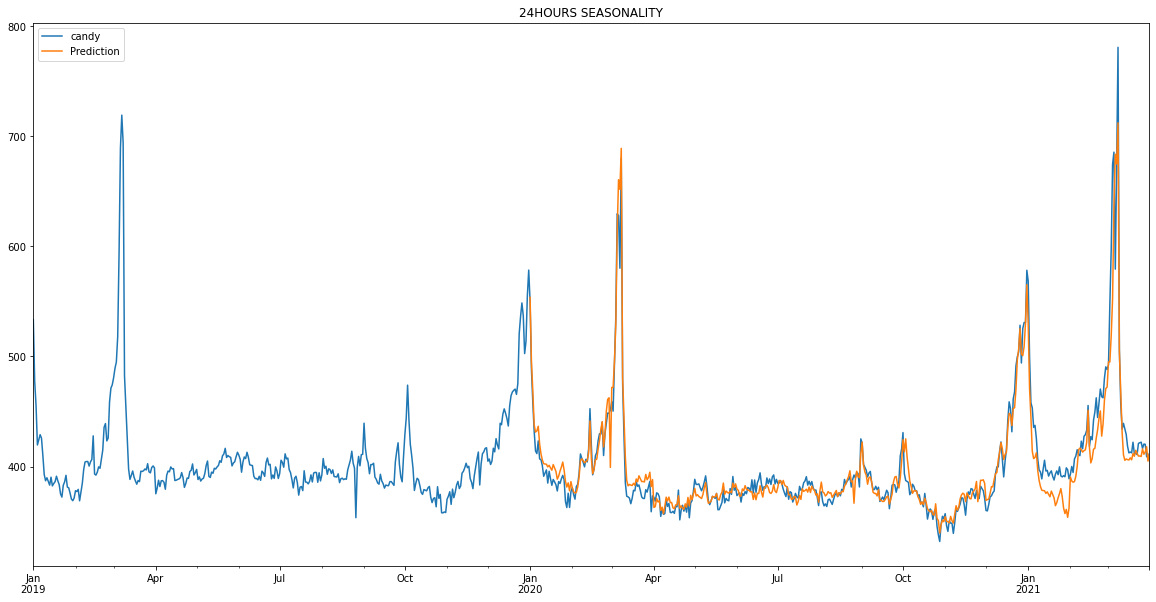

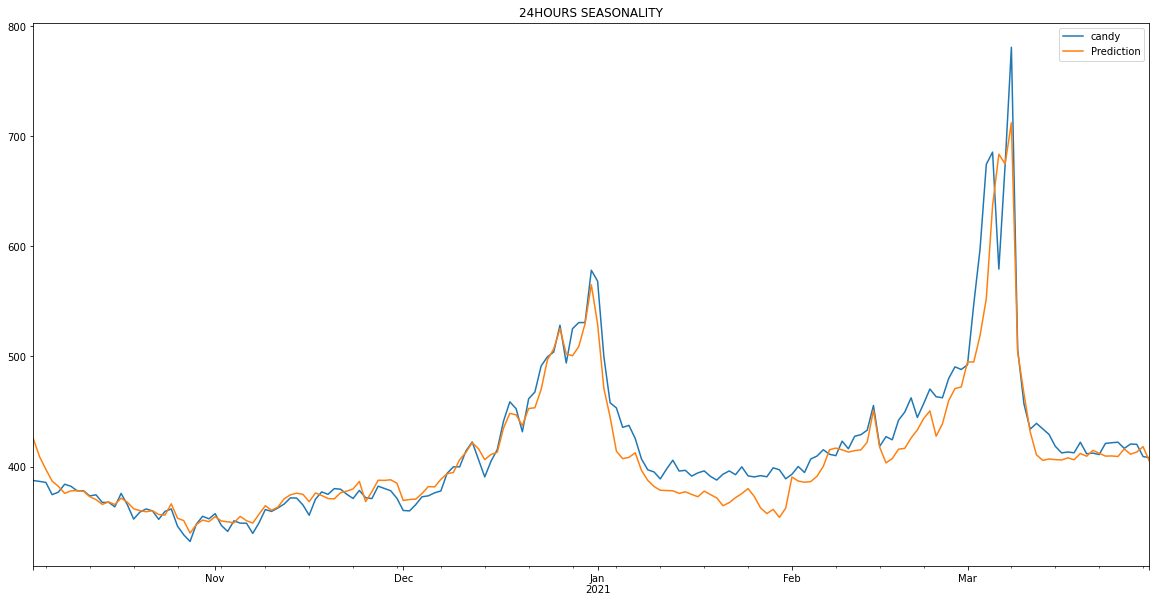

In [1763]:
offset = -180*1
my_chain = test_pipe.best_chain
my_chain.predict(pd.Timestamp('2020-01'), pd.Timestamp('2021-04'))
#my_chain.prediction[:] = ds['d'].zones[zone_n][good]['1q2021'].median()
print(my_chain.metrics, my_chain.prediction_mae(ds['d'].zones[zone_n][good], last_periods=90))
truth = ds['d'].zones[zone_n][good]
my_pred = my_chain.prediction.rename('Prediction')
pd.concat([truth, my_pred], axis=1).plot(figsize=(20, 10), title='24HOURS SEASONALITY')
pd.concat([truth, my_pred], axis=1)[offset:180+offset-1].plot(figsize=(20, 10), title='24HOURS SEASONALITY')

In [452]:
# Evaluating model of a good
metrices = []
info = []
for good_total in preds_median_1m:
    if 'sugar_value' != good_total.pipelines[0].good:
        continue
    mae = 0
    good = good_total.pipelines[0].good
    for pipe in good_total.pipelines:
        daily = ds['d'].zones[pipe.zone_n][pipe.good]
        if (daily['1q2021'] == 0).sum() / len(daily['1q2021']) > 0.01 or\
            (daily['2019'] == 0).sum() / len(daily['2019']) > 0.01:
            pass
            #continue
        mae += pipe.best_chain.mae
        reference = ds['d'].zones[pipe.zone_n][pipe.good]['1q2021'].mean()
        if reference != 0:
            mpae = pipe.best_chain.mae/ reference
        else: 
            mpae = 0
        #print(pipe.best_chain.mae, mpae, pipe.zone_n)
        info.append([pipe.best_chain.mae, pipe.zone_n, ZONES_NAMES[pipe.zone_n]['name']])
    mean_v = pd.concat(
        [ds['d'].zones[z][good]['2021'] for z in range(ZONES_CNT)], axis=0
    ).mean()
    print('average value of series \n', mean_v)
    metrics = mae / mean_v
    print(time.ctime(), good, metrics)
    metrices.append(metrics)
info.sort(reverse=True, key= lambda x: x[0])
for x in info: print(x)
print("Total metrics")
print(np.mean(metrices))
print(1/np.mean(metrices)/1000)

average value of series 
 43819.94303267992
Wed Aug 11 18:25:02 2021 sugar_value 14.781874067533254
[35084.24555555553, 49, 'Московская область']
[28499.271777777783, 76, 'Город Москва столица Российской Федерации город федерального значения']
[27668.57711111111, 51, 'Нижегородская область']
[19238.883666666676, 73, 'Челябинская область']
[18945.143777777772, 65, 'Свердловская область']
[18064.90788888889, 15, 'Республика Татарстан (Татарстан)']
[17307.537666666674, 1, 'Республика Башкортостан']
[16426.509111111118, 22, 'Краснодарский край']
[16379.572444444442, 60, 'Ростовская область']
[15517.130444444441, 53, 'Новосибирская область']
[14770.261888888885, 77, 'Город Санкт-Петербург город федерального значения']
[14292.85033333334, 58, 'Пермский край']
[13691.851111111117, 41, 'Кемеровская область - Кузбасс']
[13592.74611111111, 62, 'Самарская область']
[12640.563777777781, 63, 'Саратовская область']
[11728.840444444444, 55, 'Оренбургская область']
[11213.802666666665, 23, 'Красноярск

In [396]:
# Explore zones with 0s for a good
good = 'margarine_value'
counter = 0
idx = GOODS.index(good)
for z in range(ZONES_CNT):
    ts = ds['d'].zones[z][good]
    if 0 in ts.values:
        counter +=1
        zeros = (ts == 0).sum()
        print(zeros, zeros / ts.size, z)
print('number of zones with 0s:', counter)

7 0.008526187576126675 0
43 0.05237515225334957 3
817 0.9951278928136419 4
821 1.0 5
645 0.7856272838002436 6
173 0.21071863580998781 7
496 0.6041412911084044 8
5 0.0060901339829476245 9
2 0.00243605359317905 10
5 0.0060901339829476245 11
6 0.007308160779537149 12
7 0.008526187576126675 13
620 0.7551766138855055 14
159 0.19366626065773446 16
7 0.008526187576126675 18
821 1.0 19
2 0.00243605359317905 20
2 0.00243605359317905 21
3 0.0036540803897685747 24
1 0.001218026796589525 26
1 0.001218026796589525 29
1 0.001218026796589525 34
4 0.0048721071863581 36
2 0.00243605359317905 38
1 0.001218026796589525 39
798 0.9719853836784409 40
5 0.0060901339829476245 43
797 0.9707673568818515 48
41 0.049939098660170524 50
4 0.0048721071863581 52
1 0.001218026796589525 56
1 0.001218026796589525 57
4 0.0048721071863581 59
1 0.001218026796589525 61
754 0.9183922046285018 64
2 0.00243605359317905 66
1 0.001218026796589525 67
1 0.001218026796589525 70
1 0.001218026796589525 75
368 0.4482338611449452 78
82

<AxesSubplot:>

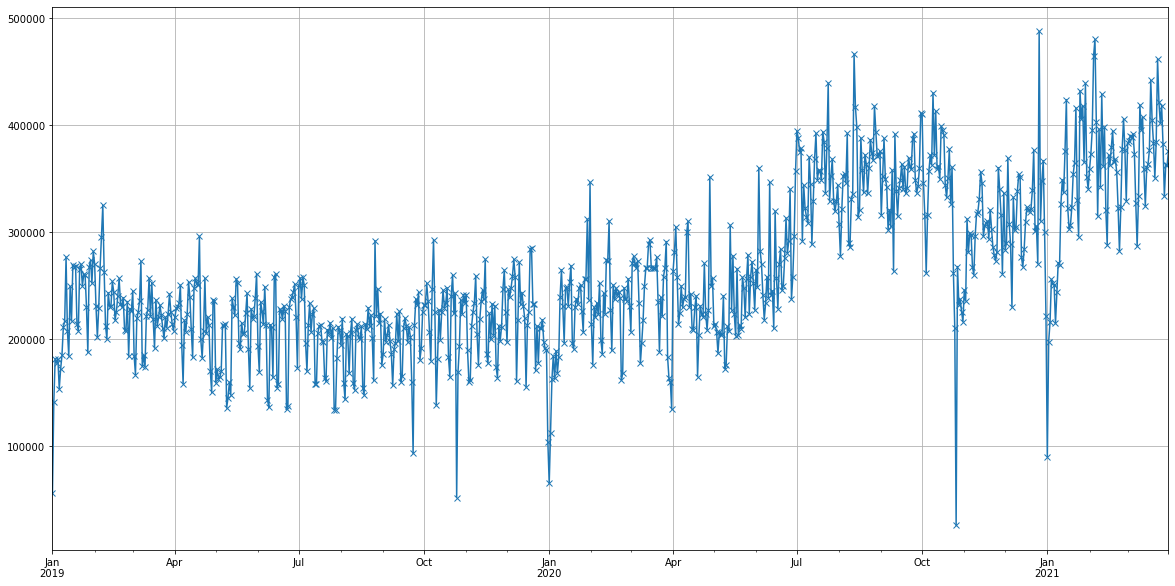

In [74]:
input_time_series.plot(figsize=(20, 10), grid=True, style='-x')

<AxesSubplot:>

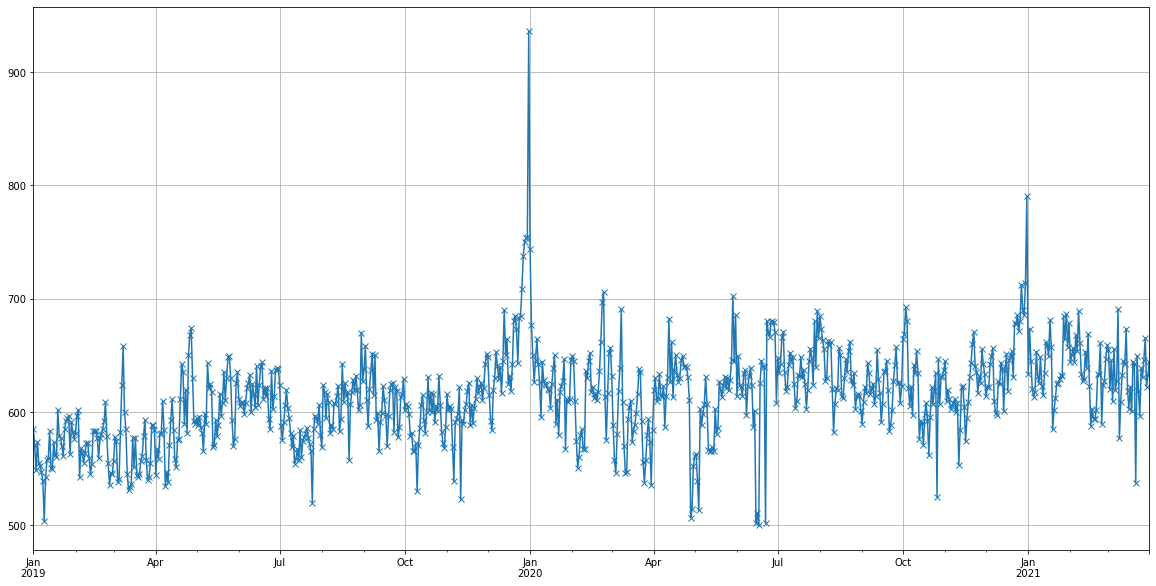

In [35]:
#ds['d'].total['potatoes_value'].plot(figsize=(20, 10), grid=True, style='-x')
ds['d'].zones[76]['fish'][:].plot(figsize=(20, 10), grid=True, style='-x')

Чувашская Республика - Чувашия


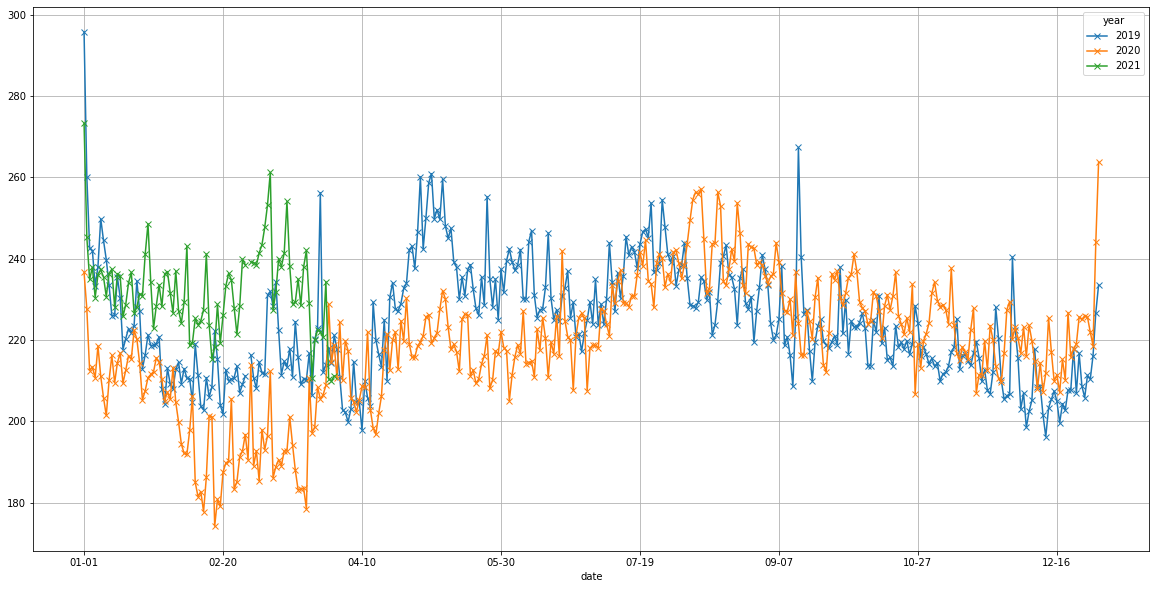

In [33]:
zone_number = 21
original = ds['d'].zones[zone_number]['pork'].copy()
#original = ds['d'].total['ai98_value'].copy()
print(ZONES_NAMES[zone_number]['name'])
test = original.to_frame()
test['date'] = original.index.strftime('%m-%d')
test['year'] = original.index.year
piv = test.pivot(index='date', columns='year')
piv.columns = piv.columns.droplevel(0)
piv[2020] = piv[2020].shift(0)
piv[2021] = piv[2021].shift(0)
#piv = piv[[2019, 2021]]
idx = pd.IndexSlice[:]
ax = piv[idx].plot(figsize=(20, 10), grid=True, style='-x')
#piv[290:].head(30)
#ax.xaxis.grid(True, which='minor', linestyle='-')

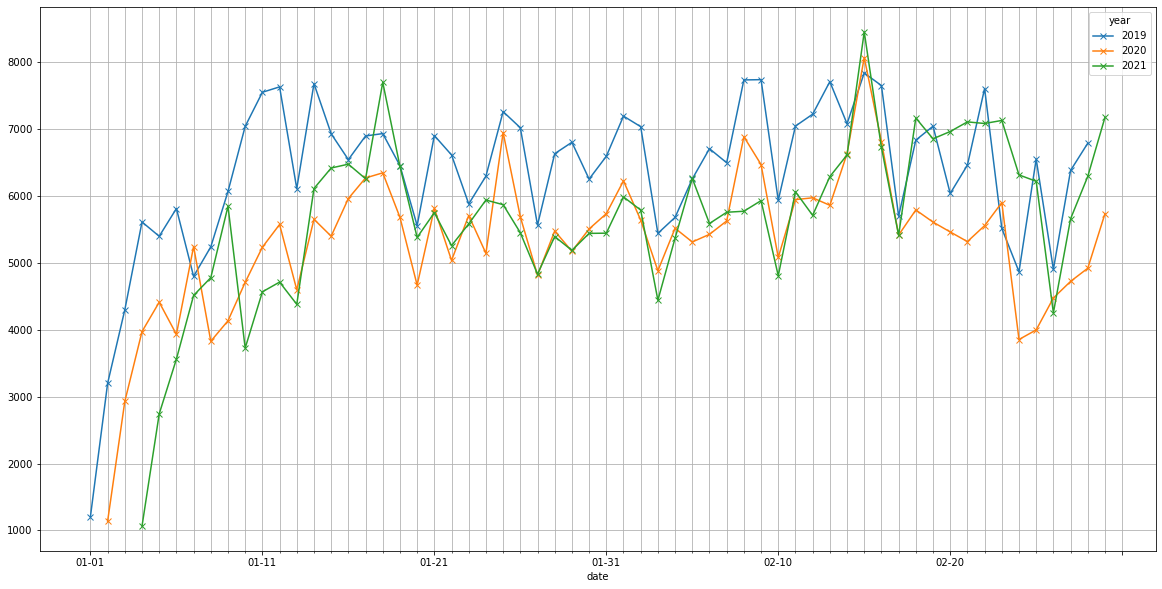

In [2458]:
xtick = list(range(len(piv[idx])))
#ax.set_xticklabels(xtick)
ax.set_xticks( xtick, minor=True)
ax.xaxis.grid(True, which='minor', linestyle='-')
ax.figure

In [ ]:
good = 'butter_value'
total_val = []
for z in range(ZONES_CNT):
    daily = ds['d'].zones[z][good]
    if 0 not in daily.values:
        total_val.append(ds['m'].zones[z][good])
total_val = sum(total_val)
total_val.pct_change()

In [475]:
# How prices and volumes in 1q2021 differ from 1q2019
volumes = [good for good in GOODS if '_value' in good]
inds = []
inds_p = []
weights = []
for vol in volumes:
    good = vol.replace('_value', '')
    ind = ds['q'].total[vol]['1q2021']/ds['q'].total[vol]['1q2019'] 
    ind_p = ds['q'].total[good]['1q2021']/ds['q'].total[good]['1q2019'] 
    inds.append(ind)
    weights.append(ds['q'].total[good].mean() / ZONES_CNT)
    print(good, ind_p, vol, ind)
weights = np.array(weights) / sum(weights)
print('average', np.average(inds, weights=weights))

pasta 1.2097328794081008 pasta_value 1.1055923309526139
legumes 1.2322198743445878 legumes_value 0.959402818348161
bread 1.1812958688861879 bread_value 1.0751192891845929
flour 1.2114680684216979 flour_value 1.1004750706369442
rice 1.1930385933534295 rice_value 1.0516957645095462
groats 1.4731486437032615 groats_value 0.9908885996396916
potatoes 1.3808105802260482 potatoes_value 1.1763748934840885
сucumbers_tomatoes 1.0517035223402895 сucumbers_tomatoes_value 1.2968323707879723
vegetables 0.9981589151656661 vegetables_value 1.2809397717714996
roots 1.2588044446609663 roots_value 1.1195891933434168
сabbage 0.6443691744392237 сabbage_value 1.1979128050182897
fruit 1.1876659246310244 fruit_value 1.0756958743619225
sugar 1.0690438566087608 sugar_value 1.159468767162859
candy 1.108757661770923 candy_value 1.0908489853554004
biscuits 1.1385025413645218 biscuits_value 1.1479046632557015
mutton 1.258450938979191 mutton_value 1.2413813054100276
beef 1.0733908404888015 beef_value 1.3356373096035